In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters
from util import process_data

import sklearn.cluster
import sklearn.neighbors
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics
import scipy
import umap
import pydeck as pdk

In [ ]:
def fit_tree(df, feature_importance):
    LEAF_SIZE = 20
    return sklearn.neighbors.KDTree(df * feature_importance, leaf_size=LEAF_SIZE)


## Actual Validation

In [3]:
def load_data():
    trips = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_scaled.feather')
    trips.set_index('rte_id', inplace=True)

    gridpts_at_rte_500 = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_500.feather')
    gridpts_at_rte_500.set_index('rte_id', inplace=True)

    grid_pts_500 = pd.read_feather(config.MODEL_PATH + 'grid_points_500.feather')
    grid_pts_500.set_index('grid_id', inplace=True)

    feature_sc = pd.read_feather(config.MODEL_PATH + 'feature_importance.feather')
    feature_scaling = dict()
    for col in trips.columns:
        if col in feature_sc.feature_names.tolist():
            feature_scaling[col] = abs(
                feature_sc[feature_sc.feature_names == col].scaling.values[0])
        else:
            feature_scaling[col] = 0.
    # Other features
    feature_scaling['popularity'] = 0.5
    feature_scaling['detour_score'] = 0.5

    return trips, grid_pts_500, gridpts_at_rte_500, feature_scaling

def fit_tree(df, feature_importance):
    LEAF_SIZE = 20
    return sklearn.neighbors.KDTree(df * feature_importance, leaf_size=LEAF_SIZE)

def neighbour_ids(chosen, trips, tree):
    dists, df_inds = tree.query(chosen, k=5)
    dists, df_inds = dists.flatten(), df_inds.flatten()
    neighbour_rte_ids = trips.index[df_inds].tolist()
    
    return neighbour_rte_ids, dists

plt.rcParams['axes.facecolor'] = '#F3F3F3'
plt.rcParams['figure.facecolor'] = '#F3F3F3'
plt.rcParams['font.size'] = 20

In [4]:
def plot_map(df_list):
    layers = []
    d=1
    c = (41.8, -74.3)
    colours = sns.color_palette(["#7A2008", "#d4350b", "#ff5224",  "#b68679", "#df8770"])
    for i, df in enumerate(df_list):
        layers += [pdk.Layer(
            type="ScatterplotLayer",
            data = pd.DataFrame({
                'coordinates': [[lon, lat] for lat, lon in zip(df.lat, df.lon)],
            }),
            filled=True,
            stroked=False,
            get_position="coordinates",
            get_radius=150,
            min_pixel_width = 5,
            get_fill_color=[int(x * 255) for x in colours[i % 5]]
        )]
        
    return pdk.Deck(
            map_style="mapbox://styles/mapbox/light-v10",
            initial_view_state=pdk.data_utils.compute_view([
                [c[1] + d, c[0] + d],
                [c[1] + d, c[0] - d],
                [c[1] - d, c[0] + d],
                [c[1] - d, c[0] - d],
            ]),
            layers=layers,
            tooltip={"html": "<b>Ride {name}</b>", "style": {"color": "white"}},
            mapbox_key=os.getenv('MAPBOX_API_KEY')
        )

In [5]:
trips, grid_pts_fine, gridpts_at_rte_fine, fs = load_data()
tree = fit_tree(trips, [v for v in fs.values()])

In [6]:
rides = pd.read_csv(config.RAW_DATA_PATH + 'ridewgps_trips.csv')
rides.drop('Unnamed: 0', axis=1, inplace=True)
rides.set_index('id', inplace=True)
rides.head()

,group_membership_id,route_id,created_at,gear_id,departed_at,duration,distance,elevation_gain,elevation_loss,visibility,...,track_id,postal_code,locality,administrative_area,country_code,source_type,short_location,highlighted_photo_id,utc_offset,avg_power_estimated
id,,,,,,,,,,,,,,,,,,,,,
51836172,52165,NaN,2020-07-03T04:58:13-07:00,NaN,2020-07-03T04:29:27-07:00,1090.0,1610.03,25.09090,42.29670,0,...,5eff1d55fa348e57b0adb16a,12538,Hyde Park,NY,US,garmin_connect,"Hyde Park, NY",0,-18000,NaN
39065273,893199,NaN,2019-08-25T09:26:55-07:00,NaN,2019-08-25T09:21:21-07:00,245.0,1610.40,10.94580,13.73830,0,...,5d62b6cfbca5927602000000,12526,Columbia County,NY,US,NaN,"Columbia County, NY",0,-18000,NaN
29695216,52165,NaN,2018-11-21T04:10:06-08:00,NaN,2018-11-21T03:23:15-08:00,1290.0,1612.79,9.27317,2.77694,0,...,5bf54b1dbca5921345000000,12538,Hyde Park,NY,US,NaN,"Hyde Park, NY",0,-18000,NaN
26105073,46030,NaN,2018-07-30T10:30:06-07:00,NaN,2018-07-30T10:07:31-07:00,1328.0,1614.05,51.64570,26.04400,0,...,5b5f4b1e4d6c4d3d0f000000,12449,Ulster County,NY,US,NaN,"Ulster County, NY",0,-18000,NaN
29695213,52165,NaN,2018-11-21T04:09:46-08:00,NaN,2018-11-21T03:12:17-08:00,604.0,1614.33,5.15784,6.20827,0,...,5bf54b0a4d6c4d0cee000000,12538,Hyde Park,NY,US,NaN,"Hyde Park, NY",0,-18000,NaN


In [204]:
trips_unscaled = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_unscaled.feather')
trips_unscaled.set_index('rte_id', inplace=True)

In [205]:
trips_unscaled = pd.merge(trips_unscaled, trips[['detour_score', 'popularity']], on='rte_id')
trips_unscaled.head()
trips_unscaled['random'] = np.random.normal(0, 1, trips_unscaled.shape[0])

In [206]:
trips_unscaled.head()

,dist,avg_slope_climbing,avg_slope_descending,max_slope,dist_climbing,dist_downhill,dist_6percent,dist_9percent,dist_12percent,detour_score,popularity,random
rte_id,,,,,,,,,,,,
7118848,47.600187,2.985415,-0.665306,13.488966,0.080159,0.030979,0.020090,0.005960,0.002252,-0.932608,-1.137800,1.027842
23586828,72.520055,3.150047,-0.437931,12.331099,0.069706,0.030336,0.019280,0.002342,0.000226,-1.452548,-1.212598,1.860636
53915665,49.712035,2.805160,-0.380623,10.831435,0.083335,0.012025,0.016504,0.002250,0.000000,-0.668803,-0.882395,1.571949
3653661,41.460804,2.883489,-0.315344,6.640965,0.085167,0.032903,0.004573,0.000000,0.000000,-0.922883,-0.124138,0.206216
5443624,19.129384,2.572793,-0.622703,7.684119,0.060159,0.038193,0.007634,0.000000,0.000000,-0.005622,-0.832813,-0.893199


In [207]:
fs_orig = fs.copy()

In [208]:
fs = fs_orig.copy()
fs['dist'] = 0.
fs['avg_slope_descending'] = 0.
fs['max_slope'] = 0.
fs['dist_6percent'] = 0.
fs['dist_12percent'] = 0.
fs['detour_score'] = 0.
fs['popularity'] = 0.
fs['random'] = 1.
fs

{'dist': 0.0,
 'avg_slope_climbing': 0.0,
 'avg_slope_descending': 0.0,
 'max_slope': 0.0,
 'dist_climbing': 0.0,
 'dist_downhill': 0.0,
 'dist_6percent': 0.0,
 'dist_9percent': 0.0,
 'dist_12percent': 0.0,
 'detour_score': 0.0,
 'popularity': 0.0,
 'random': 1.0}

In [209]:
trips_use = trips_unscaled * [v for v in fs.values()]

In [210]:
ride_users = pd.merge(trips_use[['dist']], 
                      rides.reset_index()[['id', 'user_id']].rename(columns={'id': 'rte_id'}),
                      on='rte_id', how='left')
ride_users_count = pd.DataFrame(ride_users.user_id.value_counts()).reset_index().rename(
    columns={'index': 'user_id', 'user_id': 'n_rides'})
ride_users_count = ride_users_count[ride_users_count.n_rides >= 10]
ride_users_count.shape

(90, 2)

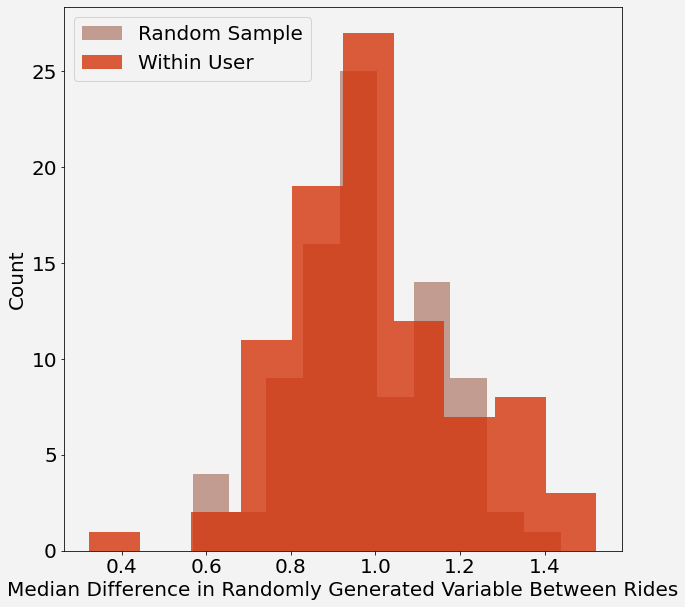

In [212]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean') # distance metric used in tree
ride_users_count['mean_dist_user'] = 0.
ride_users_count['mean_dist_all'] = 0.
ride_users_count['median_dist_user'] = 0.
ride_users_count['median_dist_all'] = 0.

for i, row in ride_users_count.iterrows():
    rte_ids = ride_users[ride_users.user_id == row.user_id].rte_id.tolist()
    
    dists_rand = dist.pairwise(
        trips_use.iloc[np.random.choice(trips_use.shape[0], len(rte_ids), replace=False)]
    )[np.triu_indices(len(rte_ids), 1)]
    
    dists_user = dist.pairwise(trips_use.loc[rte_ids])[np.triu_indices(len(rte_ids), 1)]
    
    ride_users_count.at[i, 'mean_dist_user'] = np.mean(dists_user)
    ride_users_count.at[i, 'mean_dist_all'] = np.mean(dists_rand)
    ride_users_count.at[i, 'median_dist_user'] = np.median(dists_user)
    ride_users_count.at[i, 'median_dist_all'] = np.median(dists_rand)

plt.figure(figsize=(10, 10))
# bins = np.arange(0.2, 1.7, 0.1)
# plt.hist(ride_users_count.mean_dist_all, color='#B68679CC', label='Random Sample', bins=bins)
# plt.hist(ride_users_count.mean_dist_user, color='#D4350BCC', label='Within User', bins=bins)
# plt.xlabel('Mean Normalised Distance')
plt.hist(ride_users_count.median_dist_all, color='#B68679CC', label='Random Sample')#, bins=bins)
plt.hist(ride_users_count.median_dist_user, color='#D4350BCC', label='Within User')#, bins=bins)
plt.xlabel('Median Difference in Randomly Generated Variable Between Rides')
plt.ylabel('Count')
plt.legend()

In [ ]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
dists_all = dist.pairwise(trips_use)[np.triu_indices(trips_use.shape[0], 1)]
#bins = np.arange(1.5, 5, 0.25)
a = pd.DataFrame({'Inter-ride Distance': dists_all})
a['Type'] = 'All Rides'

b = pd.DataFrame(columns=['Inter-ride Distance', 'Type'])
for i, row in ride_users_count.iterrows():
    if not i % 100: print(i)
    rte_ids = ride_users[ride_users.user_id == row.user_id].rte_id.tolist()
    dists_user = dist.pairwise(trips_use.loc[rte_ids])[np.triu_indices(len(rte_ids), 1)]
    b = pd.concat((b, pd.DataFrame({'Inter-ride Distance': dists_user, 'Type': 'Within User'})))
# sns.displot(dists_all, stat='density')

(0.0, 6.0)

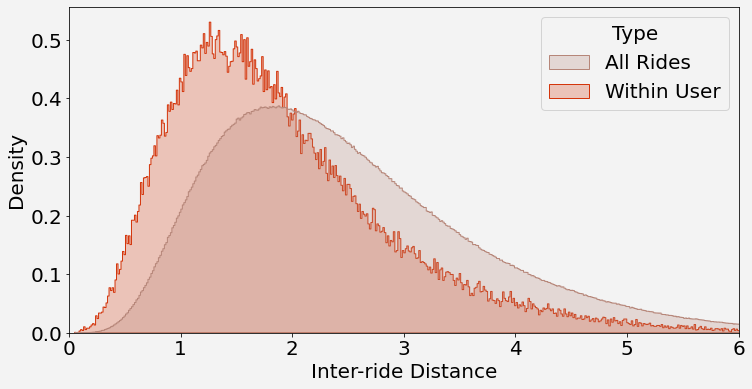

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(pd.concat((a, b)), x='Inter-ride Distance', hue='Type', stat='density', common_norm=False,
             ax=ax, palette=['#B68679', '#D4350B'], element='step')
plt.xlim([0, 6])

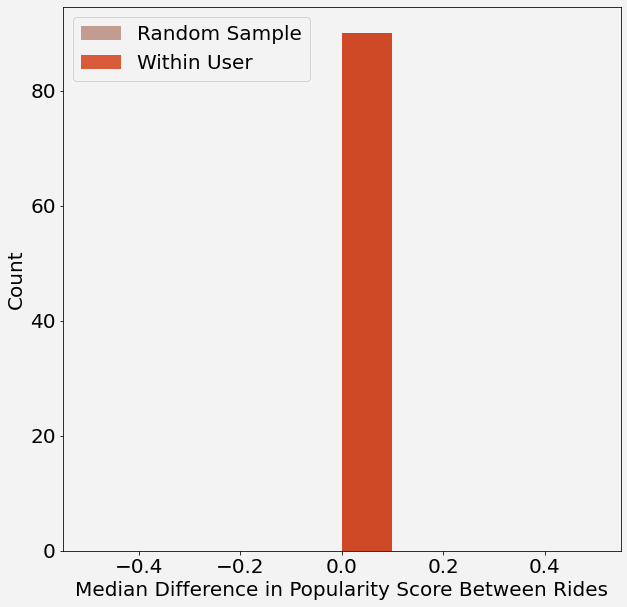

In [187]:
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean') # distance metric used in tree
ride_users_count['mean_dist_user'] = 0.
ride_users_count['mean_dist_all'] = 0.
ride_users_count['median_dist_user'] = 0.
ride_users_count['median_dist_all'] = 0.

for i, row in ride_users_count.iterrows():
    rte_ids = ride_users[ride_users.user_id == row.user_id].rte_id.tolist()
    
    dists_rand = dist.pairwise(
        trips_use.iloc[np.random.choice(trips_use.shape[0], len(rte_ids), replace=False)]
    )[np.triu_indices(len(rte_ids), 1)]
    
    dists_user = dist.pairwise(trips_use.loc[rte_ids])[np.triu_indices(len(rte_ids), 1)]
    
    ride_users_count.at[i, 'mean_dist_user'] = np.mean(dists_user)
    ride_users_count.at[i, 'mean_dist_all'] = np.mean(dists_rand)
    ride_users_count.at[i, 'median_dist_user'] = np.median(dists_user)
    ride_users_count.at[i, 'median_dist_all'] = np.median(dists_rand)

plt.figure(figsize=(10, 10))
# bins = np.arange(0.2, 1.7, 0.1)
# plt.hist(ride_users_count.mean_dist_all, color='#B68679CC', label='Random Sample', bins=bins)
# plt.hist(ride_users_count.mean_dist_user, color='#D4350BCC', label='Within User', bins=bins)
# plt.xlabel('Mean Normalised Distance')
plt.hist(ride_users_count.median_dist_all, color='#B68679CC', label='Random Sample')#, bins=bins)
plt.hist(ride_users_count.median_dist_user, color='#D4350BCC', label='Within User')#, bins=bins)
plt.xlabel('Median Difference in Climbing Distance Between Rides')
plt.ylabel('Count')
plt.legend()

In [71]:
user_id = 772671

rte_dfs = []
rte_ids = ride_users[ride_users.user_id == user_id].rte_id.tolist()
for rte_id in rte_ids:
    rte_dfs += [grid_pts_fine.loc[gridpts_at_rte_fine.loc[rte_id].grid_ids]]

# r = plot_map(rte_dfs)
# r.to_html()

Mean: 2.52, Std: 1.12, Median: 2.37, max: 7.179445621879996
Mean: 1.88, Std: 1.14, Median: 1.64, Max: 8.782481002333219


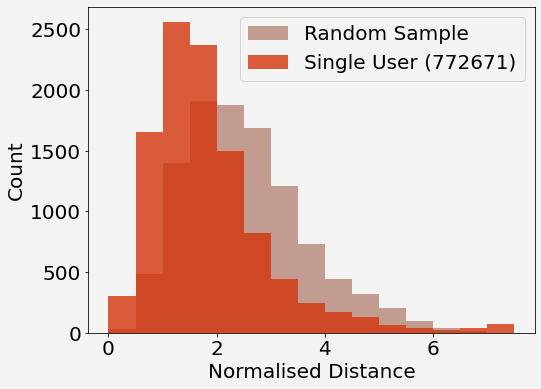

In [73]:
bins=np.arange(0, 8, 0.5)
plt.figure(figsize=(8, 6))
dist = sklearn.neighbors.DistanceMetric.get_metric('euclidean') # distance metric used in tree
dists = dist.pairwise(trips_use.iloc[np.random.randint(0, trips_use.shape[0], len(rte_ids))])
dists = dists[np.triu_indices(dists.shape[0], 1)]
print('Mean: {:.2f}, Std: {:.2f}, Median: {:.2f}, max: {}'.format(
    np.mean(dists), np.std(dists), np.median(dists), np.max(dists)))
plt.hist(dists, color='#B68679CC', bins=bins, label='Random Sample')
dists = dist.pairwise(trips_use.loc[rte_ids])
dists = dists[np.triu_indices(dists.shape[0], 1)]
print('Mean: {:.2f}, Std: {:.2f}, Median: {:.2f}, Max: {}'.format(
    np.mean(dists), np.std(dists), np.median(dists), np.max(dists)))
plt.hist(dists, color='#D4350BCC', bins=bins, label='Single User ({})'.format(user_id))
plt.xlabel('Normalised Distance')
plt.ylabel('Count')
plt.legend()